
# Cassava Leaf Disease Detection


## Using Neural Network Models to Identify Diseased Plants

### Lynn Anderson



# All Models

This notebook contains every model looked at. Most performed very poorly and many iterations were investigated before a satisfactory model was reached. 

# Data Preparation



In [1]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import PIL.Image as Image
from keras.applications import ResNet50V2 
import lime
import warnings
warnings.simplefilter("ignore")

%matplotlib inline


### Function to visualize model performance

This function plots the accuracy of both training and validation data across the number of epochs.

In [2]:
def visualize_training_results(results):
    
    history = results.history
    
    plt.figure(figsize=(5, 3))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [3]:
for sub in os.listdir("./data/short"):
    print(os.listdir("./data/short/" + sub)[:5])
    print(np.shape(os.listdir("./data/short/" + sub)))

['train-cbb-0.jpg', 'train-cbb-1.jpg', 'train-cbb-10.jpg', 'train-cbb-100.jpg', 'train-cbb-101.jpg']
(300,)
['train-cbsd-0.jpg', 'train-cbsd-1.jpg', 'train-cbsd-10.jpg', 'train-cbsd-100.jpg', 'train-cbsd-101.jpg']
(300,)
['train-cgm-0.jpg', 'train-cgm-1.jpg', 'train-cgm-10.jpg', 'train-cgm-100.jpg', 'train-cgm-101.jpg']
(300,)
['train-cmd-0.jpg', 'train-cmd-1.jpg', 'train-cmd-10.jpg', 'train-cmd-100.jpg', 'train-cmd-101.jpg']
(300,)
['train-healthy-0.jpg', 'train-healthy-1.jpg', 'train-healthy-10.jpg', 'train-healthy-100.jpg', 'train-healthy-101.jpg']
(300,)


Each subdirectory contains its respective class of images in a jpg format.

### Preprocess images

In [4]:
# augments and preprocesses images 

train_data_dir = 'data/short'

# Get all the data in the directory and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(128, 128), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


#### preview image labels

In [5]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [6]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))

(1500, 128, 128, 3)
(1500, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [7]:
train_img_unrow = train_images.reshape(1500, -1)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(1500, 49152)


#### normalize pixel values

In [8]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased. First, a dataframe was made from the dataset for easier manipulation.

In [9]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [10]:
# add column for diseased and healthy
df.loc[df[4]==1,"Healthy"]=1
df.loc[df[4]==0,"Healthy"]=0
df.loc[df[4]==1,"Diseased"]=0
df.loc[df[4]==0,"Diseased"]=1
df.head()

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
#drop other columns and preview
df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
df.head()

,Healthy,Diseased
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [12]:
# check for any null entries
df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [13]:
df['Healthy'].sum()


300.0

In [14]:
df['Diseased'].sum()


1200.0

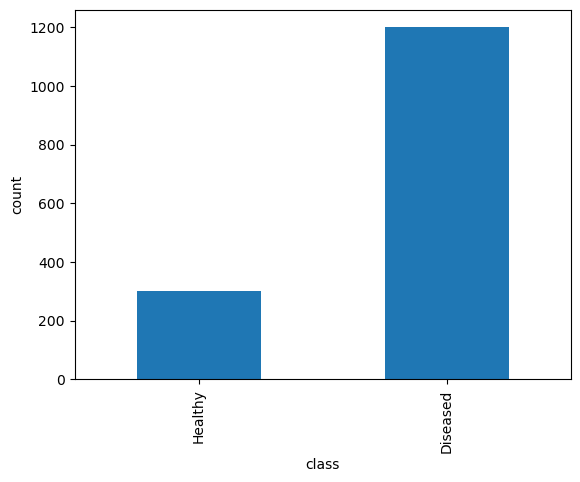

In [15]:
#visualize class imbalance
df.sum().plot(kind='bar', xlabel='class', ylabel='count');

In this analysis, diseased plants outnumber healthy ones 4 to 1.

# Modeling

This section is divided into several subsections- first, multiclass classification networks were investigated- basic neural network models, followed by CNNs and a Pretrained Resnet model. Performance was very poor overall- the best model, the pretrained ResNet, had an F-1 score of .46. In general, model scores for precision, recall, and F-1 were rarely above 0.3. Thus, all multiclass classification models failed to satisfactorily classify the plants into the correct one of five categories it belonged to. 

Then, a binary classification strategy was used to investigate models on classifying plants as either healthy or diseased. Rather than attempt to identify the specific disease using a neural network model, an important first step is to figure out if an image depict a plant that is healthy or diseased. Then, an expert, or perhaps more robust model, could accurately diagnose the specific disease condition. Again, basic neural networks were first trained and evaluated, followed by a CNN and the Resnet model.  For this situation, minimizing false negatives is important, since a plant labelled as healthy when it is actually diseased would be detrimental to the customer, as their plants might go untreated would be the worst case. Thus, recall and F-1 score were used to evaluate model performance. 

## Baseline Neural Network models

To begin with, basic neural network models with 1, 2, and 3 hidden dense layers were trained and evaluated. A small grid search was then performed to discover optimal parameters, followed by models with differnt regularization techniques. The basic network with 2 hidden layers, the grid search best parameter model, and the L2 model performed better than the others, with F-1 scores of .28, .29, and .22, respectively. Overall, model performance was very poor. On all the models except the three mentioned above, at least one class had an F-1 score of 0, while the others had at least one class with an F-1 score of below .12. 

#### train-test split

In [16]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, 
                                                                     y_train, 
                                                                     test_size=0.2, 
                                                                     random_state=42,
                                                                     shuffle=True)

### Basic neural network model with 1 hidden layer

In [27]:
#instantiate and train model  

np.random.seed(42)

model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model_1.summary()
results_1 = model_1.fit(final_train, 
                        train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(final_test, test_labels))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 12584453 (48.01 MB)
Trainable params: 12584453 (48.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


100/100 [==============================] - 7s 62ms/step - loss: 2.0079 - acc: 0.1900 - val_loss: 1.6081 - val_acc: 0.2267
Epoch 2/10
100/100 [==============================] - 6s 57ms/step - loss: 1.6597 - acc: 0.2183 - val_loss: 1.6900 - val_acc: 0.2267
Epoch 3/10
100/100 [==============================] - 6s 64ms/step - loss: 1.6443 - acc: 0.2242 - val_loss: 1.7935 - val_acc: 0.1733
Epoch 4

### Evaluation

In [28]:
y_pred = model_1.predict(final_test)

10/10 [==============================] - 0s 16ms/step


In [29]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.24      0.35        67
           1       0.40      0.04      0.08        47
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        67
           4       0.24      0.96      0.38        68

    accuracy                           0.28       300
   macro avg       0.26      0.25      0.16       300
weighted avg       0.27      0.28      0.18       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


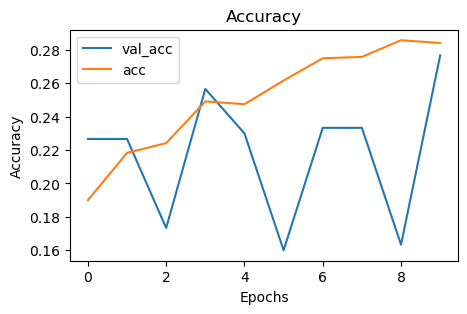

In [30]:
visualize_training_results(results_1)

Overall this model performs rather poorly. It will be necessary to experiment with different parameters, numbers of layers, and model types. The training accuracy slowly increases over the number of epochs; however the validation data does not, suggesting 10 epochs is plenty and that additional epochs could result in overfitting.

### Neural network with 2 hidden layers

Next I looked at a model with an additional hidden layer. It performed slightly better.

In [55]:
np.random.seed(42)
model_2 = models.Sequential()
model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(5, activation='sigmoid'))
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_2 = model_2.fit(final_train,
                    train_labels,
                    epochs=10,
                    batch_size=12,
                    validation_data=(final_test, test_labels))

Epoch 1/10
100/100 [==============================] - 8s 73ms/step - loss: 0.5152 - acc: 0.2217 - val_loss: 0.5101 - val_acc: 0.2300
Epoch 2/10
100/100 [==============================] - 6s 62ms/step - loss: 0.4975 - acc: 0.2533 - val_loss: 0.4953 - val_acc: 0.2967
Epoch 3/10
100/100 [==============================] - 6s 59ms/step - loss: 0.4954 - acc: 0.2808 - val_loss: 0.4908 - val_acc: 0.2867
Epoch 4/10
100/100 [==============================] - 6s 63ms/step - loss: 0.4865 - acc: 0.3017 - val_loss: 0.4930 - val_acc: 0.2600
Epoch 5/10
100/100 [==============================] - 6s 61ms/step - loss: 0.4837 - acc: 0.3133 - val_loss: 0.4864 - val_acc: 0.3233
Epoch 6/10
100/100 [==============================] - 6s 63ms/step - loss: 0.4766 - acc: 0.3442 - val_loss: 0.4971 - val_acc: 0.2633
Epoch 7/10
100/100 [==============================] - 6s 59ms/step - loss: 0.4675 - acc: 0.3575 - val_loss: 0.5341 - val_acc: 0.2000
Epoch 8/10
100/100 [==============================] - 6s 65ms/step - 

### Evaluation

In [38]:
y_pred = model_2.predict(final_test)

10/10 [==============================] - 0s 14ms/step


In [39]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.34      0.47      0.40        55
           1       0.20      0.08      0.12        61
           2       0.36      0.23      0.28        69
           3       0.29      0.42      0.34        66
           4       0.27      0.31      0.29        49

    accuracy                           0.30       300
   macro avg       0.29      0.30      0.28       300
weighted avg       0.29      0.30      0.28       300



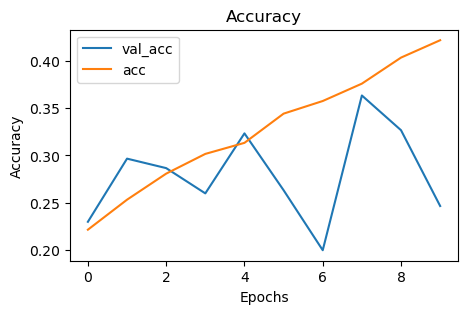

In [56]:
visualize_training_results(results_2)

The metrics for this model are considerably improved upon the first model, yet still very low.

### Neural nettwork model with 3 hidden layers

I wanted to see how adding another hidden layer would affect performance. 

In [58]:
np.random.seed(42)
model_3 = models.Sequential()
model_3.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(5, activation='sigmoid'))
model_3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['acc'])

results_3 = model_3.fit(final_train,
                    train_labels,
                    epochs=5,
                    batch_size=16,
                    validation_data=(final_test, test_labels))

Epoch 1/5
75/75 [==============================] - 5s 64ms/step - loss: 1.6149 - acc: 0.1942 - val_loss: 1.6104 - val_acc: 0.1567
Epoch 2/5
75/75 [==============================] - 5s 63ms/step - loss: 1.6094 - acc: 0.2108 - val_loss: 1.6111 - val_acc: 0.1567
Epoch 3/5
75/75 [==============================] - 5s 63ms/step - loss: 1.6093 - acc: 0.2108 - val_loss: 1.6117 - val_acc: 0.1567
Epoch 4/5
75/75 [==============================] - 4s 60ms/step - loss: 1.6092 - acc: 0.2108 - val_loss: 1.6122 - val_acc: 0.1567
Epoch 5/5
75/75 [==============================] - 4s 58ms/step - loss: 1.6091 - acc: 0.1817 - val_loss: 1.6126 - val_acc: 0.1567


### Evaluation

In [166]:
y_pred = model_3.predict(final_test)

10/10 [==============================] - 0s 14ms/step


In [167]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00        66
           4       0.16      1.00      0.28        49

    accuracy                           0.16       300
   macro avg       0.03      0.20      0.06       300
weighted avg       0.03      0.16      0.05       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


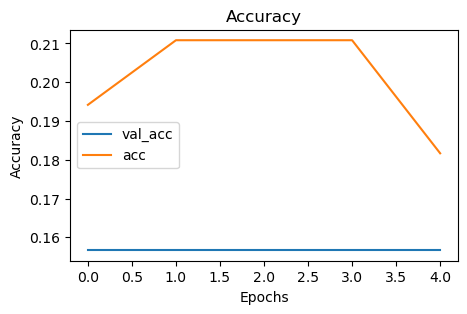

In [59]:
visualize_training_results(results_3)

The additional layer resulted in a much poorer model.

### Grid search to find optimal parameters

I wanted to experiment with different optimizers, batch sizes, and epochs to find the optimal parameters for the neural nework model. I will be using 2 hidden layers since that was the best performing model.


In [31]:
def buildModel(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu', input_shape=(49152,))) 
    
    # Adding the second hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
        
    # Adding the output layer
    classifier.add(layers.Dense(5, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [200]:
classifier = KerasRegressor(build_fn = buildModel('adam'))

#What hyperparameter we want to play with

parameters = {'batch_size': [16, 32, 64],
              'epochs': [10, 50],
              'optimizer': ['adam', 'sgd']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
grid_search = grid_search.fit(final_train, train_labels, verbose = 0)

INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxvpl28j0\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxvpl28j0\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0zrjr1wh\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0zrjr1wh\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoio9skjk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoio9skjk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbrts_bvd\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbrts_bvd\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 18ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4k0zp5t4\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4k0zp5t4\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6eerd8wo\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6eerd8wo\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfjk8a53q\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfjk8a53q\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5ir2u938\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5ir2u938\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkusk4iwo\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkusk4iwo\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpi_zmhqhm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpi_zmhqhm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl1kvta5y\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl1kvta5y\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2c1_8plv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2c1_8plv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8970k2dw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8970k2dw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx3__my6r\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx3__my6r\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphoozyckc\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphoozyckc\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp50h0ehyf\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp50h0ehyf\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_q6hyhdv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_q6hyhdv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsi8npt5a\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsi8npt5a\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl1ixu5_y\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl1ixu5_y\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8o_d7mau\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8o_d7mau\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfhruhhp_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfhruhhp_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 6ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptuwrv_6r\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptuwrv_6r\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yjwn4b_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yjwn4b_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdowevjng\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdowevjng\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf_9yfbah\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf_9yfbah\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yixz2yl\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yixz2yl\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp36bsrvek\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp36bsrvek\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyc8vq6nu\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyc8vq6nu\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptsn9xpls\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptsn9xpls\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyzv4at24\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyzv4at24\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8o37m3p3\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8o37m3p3\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppc9embbh\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppc9embbh\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 17ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq8bx44_j\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq8bx44_j\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpr60l0dvi\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpr60l0dvi\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphoomjhfy\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphoomjhfy\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5sjyfbhe\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5sjyfbhe\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxm6wccsp\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxm6wccsp\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp00cuvxzw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp00cuvxzw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpit_0b_o8\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpit_0b_o8\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7k9byeeb\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7k9byeeb\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptnmr_sgk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptnmr_sgk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6efzommt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6efzommt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp93fzs2i6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp93fzs2i6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3r2rc87z\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3r2rc87z\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpk9yp5tz5\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpk9yp5tz5\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9n8vncy6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9n8vncy6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpepqlwlan\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpepqlwlan\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6dbshw0u\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6dbshw0u\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 21ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpwyqhjmtb\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpwyqhjmtb\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzknkrsgl\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzknkrsgl\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8f736wow\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8f736wow\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9hhn7cua\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9hhn7cua\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzv6a3fgu\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzv6a3fgu\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgz9l8krb\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgz9l8krb\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 31ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpetwv6fup\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpetwv6fup\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgx3d5ctv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgx3d5ctv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpz0m8luny\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpz0m8luny\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiq2lothm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiq2lothm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb9zfydqb\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb9zfydqb\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1505w_dz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1505w_dz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgj22f9_a\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgj22f9_a\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdspj43fr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdspj43fr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbk1i3bgt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbk1i3bgt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [201]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 50, 'optimizer': 'sgd'}


The best parameters for data are a batch size of 16, 50 epochs, and the sgd optimizer.

In [38]:
# build model with the resulting best parameters

bestClassifier = buildModel('sgd')
HistoryBest = bestClassifier.fit(final_train, train_labels, batch_size = 16, epochs =50 , verbose = 0, validation_data=(final_test, test_labels))


### Evaluation

In [41]:
y_pred = bestClassifier.predict(final_test)

10/10 [==============================] - 0s 9ms/step


In [42]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.50      0.24      0.32        67
           1       0.24      0.21      0.22        47
           2       0.16      0.59      0.26        51
           3       0.27      0.09      0.13        67
           4       0.50      0.15      0.23        68

    accuracy                           0.24       300
   macro avg       0.33      0.26      0.23       300
weighted avg       0.35      0.24      0.23       300



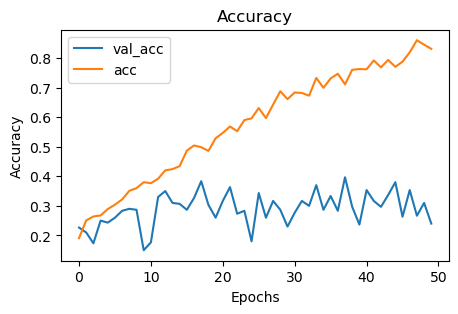

In [43]:
visualize_training_results(HistoryBest)

While this model performs a bit better than the earlier network with 2 hidden layers, it still does not satisfactorily classify the images. Additionally, the validation data accuracy does not increase much after 10 epochs, indicating the additional epochs just add to the runtime without adding much value.

### Neural Network model with L2 regularization

L2 regularization reduces the possibility of overfitting by keeping the values of the weights and biases small by adding a penalty equal to the square of the magnitude of coefficient.

In [61]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(49152,)))

# Add another hidden layer
L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='sgd', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_results = L2_model.fit(final_train, 
                            train_labels, 
                            epochs=10, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
75/75 [==============================] - 5s 55ms/step - loss: 3.2080 - acc: 0.2175 - val_loss: 3.1170 - val_acc: 0.2067
Epoch 2/10
75/75 [==============================] - 3s 47ms/step - loss: 3.1008 - acc: 0.2308 - val_loss: 3.0976 - val_acc: 0.2200
Epoch 3/10
75/75 [==============================] - 4s 53ms/step - loss: 3.0733 - acc: 0.2242 - val_loss: 3.0528 - val_acc: 0.2500
Epoch 4/10
75/75 [==============================] - 4s 48ms/step - loss: 3.0490 - acc: 0.2358 - val_loss: 3.0280 - val_acc: 0.2833
Epoch 5/10
75/75 [==============================] - 4s 50ms/step - loss: 3.0079 - acc: 0.2600 - val_loss: 2.9894 - val_acc: 0.2933
Epoch 6/10
75/75 [==============================] - 4s 50ms/step - loss: 2.9905 - acc: 0.2750 - val_loss: 2.9722 - val_acc: 0.3000
Epoch 7/10
75/75 [==============================] - 4s 50ms/step - loss: 2.9471 - acc: 0.2950 - val_loss: 2.9516 - val_acc: 0.3033
Epoch 8/10
75/75 [==============================] - 4s 50ms/step - loss: 2.9233 - a

### Evaluation

In [168]:
y_pred = L2_model.predict(final_test)

10/10 [==============================] - 0s 10ms/step


In [169]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.34      0.62      0.44        55
           1       0.27      0.13      0.18        61
           2       0.50      0.03      0.05        69
           3       0.36      0.47      0.41        66
           4       0.29      0.49      0.37        49

    accuracy                           0.33       300
   macro avg       0.35      0.35      0.29       300
weighted avg       0.36      0.33      0.28       300



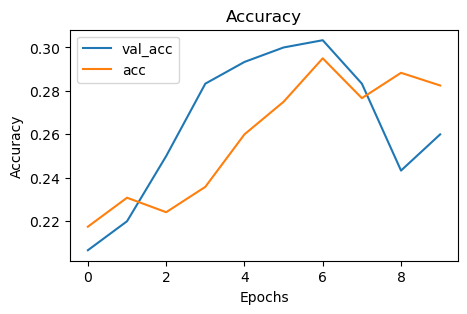

In [62]:
visualize_training_results(L2_model_results)

The model looks to perform similarily to the grid search model. 

### Neural network model with L1 regularization

The L1 penalty is equal to the absolute value of the magnitude of coefficient.

In [171]:
np.random.seed(42)

L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(49152,)))

# Add a hidden layer
L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='sgd', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(final_train, 
                            train_labels,
                            epochs=10, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
75/75 [==============================] - 6s 74ms/step - loss: 125.8763 - acc: 0.1725 - val_loss: 79.4624 - val_acc: 0.2200
Epoch 2/10
75/75 [==============================] - 5s 64ms/step - loss: 47.6925 - acc: 0.1850 - val_loss: 21.8370 - val_acc: 0.1633
Epoch 3/10
75/75 [==============================] - 5s 65ms/step - loss: 9.9406 - acc: 0.1992 - val_loss: 5.3583 - val_acc: 0.2200
Epoch 4/10
75/75 [==============================] - 5s 69ms/step - loss: 5.0447 - acc: 0.1975 - val_loss: 4.4736 - val_acc: 0.1633
Epoch 5/10
75/75 [==============================] - 6s 78ms/step - loss: 4.4749 - acc: 0.1992 - val_loss: 4.4853 - val_acc: 0.2300
Epoch 6/10
75/75 [==============================] - 5s 67ms/step - loss: 4.4173 - acc: 0.2092 - val_loss: 4.8782 - val_acc: 0.2200
Epoch 7/10
75/75 [==============================] - 5s 64ms/step - loss: 4.1574 - acc: 0.1825 - val_loss: 3.9512 - val_acc: 0.2033
Epoch 8/10
75/75 [==============================] - 5s 65ms/step - loss: 3.961

### Evaluation

In [172]:
y_pred = L1_model.predict(final_test)

10/10 [==============================] - 0s 11ms/step


In [173]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.18      1.00      0.31        55
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00        66
           4       0.00      0.00      0.00        49

    accuracy                           0.18       300
   macro avg       0.04      0.20      0.06       300
weighted avg       0.03      0.18      0.06       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
visualize_training_results(L1_model_val)

This model performs extremely poorly.

### Neural network with dropout regularization

Dropout regularization is another tecnique used when the model overfits the data. 

In [17]:
np.random.seed(42)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(49152,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(5, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='sgd', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(final_train, 
                                      train_labels,
                                      epochs=10, 
                                      batch_size=16, 
                                      validation_data=(final_test, test_labels))



Epoch 1/10


75/75 [==============================] - 7s 66ms/step - loss: 1.7447 - acc: 0.1925 - val_loss: 1.6102 - val_acc: 0.1833
Epoch 2/10
75/75 [==============================] - 5s 62ms/step - loss: 1.6099 - acc: 0.2042 - val_loss: 1.6104 - val_acc: 0.1833
Epoch 3/10
75/75 [==============================] - 5s 70ms/step - loss: 1.6100 - acc: 0.2050 - val_loss: 1.6105 - val_acc: 0.1833
Epoch 4/10
75/75 [==============================] - 4s 58ms/step - loss: 1.6097 - acc: 0.2033 - val_loss: 1.6107 - val_acc: 0.1833
Epoch 5/10
75/75 [==============================] - 4s 59ms/step - loss: 1.6101 - acc: 0.2033 - val_loss: 1.6118 - val_acc: 0.1767
Epoch 6/10
75/75 [==============================] - 5s 63ms/step - loss: 1.6095 - acc: 0.2050 - val_loss: 1.6108 - val_acc: 0.1833
Epoch 7/10
75/75 [==============================] - 4s 60ms/step - loss: 1.6095 - acc: 0.2017 - val_loss: 1.6108 - val_acc: 0.1833
Epoch 8/10
75/75 [==============================] - 5s 62ms/step - loss: 1.6097

### Evaluation

In [18]:
y_pred = dropout_model.predict(final_test)

10/10 [==============================] - 0s 12ms/step


In [19]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.18      1.00      0.31        55
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        66
           4       0.00      0.00      0.00        57

    accuracy                           0.18       300
   macro avg       0.04      0.20      0.06       300
weighted avg       0.03      0.18      0.06       300



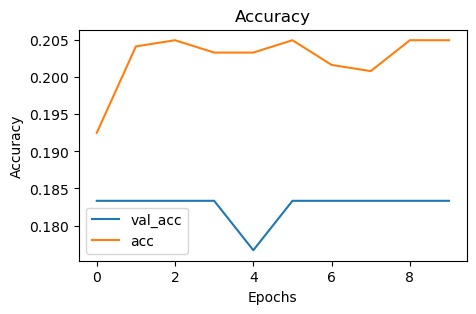

In [20]:
visualize_training_results(dropout_model_val)

This model also performs very poorly, appearing to predict mostly images of healthy plants. 

## Convoluted Neural Network (CNN) model

CNN models are known to perform well on image recognition tasks. Rather than just looking at individual pixels,they learn local patterns by grouping adjacent pixels.Thus, when a convolutional neural network recognizes a pattern in one region, these insights can be shared and applied to other regions. Additionally, deeper CNNs can learn spatial hierarchies- for example, a first layer will learn small local patterns, a second layer will learn larger patterns using features of the first layer patterns, etc.

As expected, the CNN outperformed the other previous models overall when considering the precision, recall, and F-1 scores of the classes. However, with most F-1 scores below .5, it is still not satisfactory.

#### train-test split for CNN modeling

In [38]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, 
                                                                         y_train, 
                                                                         test_size=0.2, 
                                                                         random_state=42,
                                                                         shuffle=True)

In [39]:
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))


Epoch 1/10
75/75 [==============================] - 13s 145ms/step - loss: 1.6184 - acc: 0.2042 - auc: 0.4975 - val_loss: 1.6163 - val_acc: 0.2133 - val_auc: 0.5040
Epoch 2/10
75/75 [==============================] - 9s 123ms/step - loss: 1.6067 - acc: 0.2258 - auc: 0.5251 - val_loss: 1.6097 - val_acc: 0.2067 - val_auc: 0.5293
Epoch 3/10
75/75 [==============================] - 9s 115ms/step - loss: 1.6001 - acc: 0.2492 - auc: 0.5545 - val_loss: 1.6053 - val_acc: 0.2100 - val_auc: 0.5426
Epoch 4/10
75/75 [==============================] - 9s 114ms/step - loss: 1.5894 - acc: 0.2658 - auc: 0.5826 - val_loss: 1.5933 - val_acc: 0.2567 - val_auc: 0.5615
Epoch 5/10
75/75 [==============================] - 9s 121ms/step - loss: 1.5810 - acc: 0.2758 - auc: 0.5927 - val_loss: 1.5867 - val_acc: 0.2400 - val_auc: 0.5730
Epoch 6/10
75/75 [==============================] - 9s 122ms/step - loss: 1.5606 - acc: 0.2825 - auc: 0.6173 - val_loss: 1.5683 - val_acc: 0.3000 - val_auc: 0.6074
Epoch 7/10
75/

### Evaluation

In [40]:
y_pred = cnn_model.predict(cnn_test)

10/10 [==============================] - 1s 52ms/step


In [41]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        66
           1       0.33      0.53      0.41        60
           2       0.25      0.88      0.39        60
           3       0.27      0.86      0.41        58
           4       0.22      0.80      0.35        56

   micro avg       0.27      0.68      0.39       300
   macro avg       0.29      0.69      0.39       300
weighted avg       0.30      0.68      0.39       300
 samples avg       0.28      0.68      0.39       300



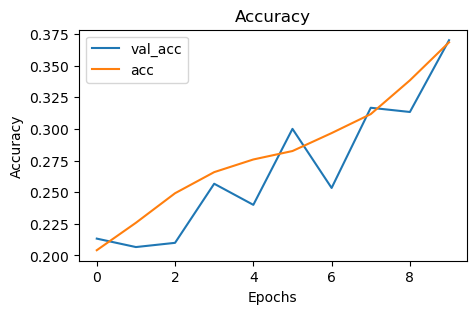

In [42]:
visualize_training_results(cnn_results)

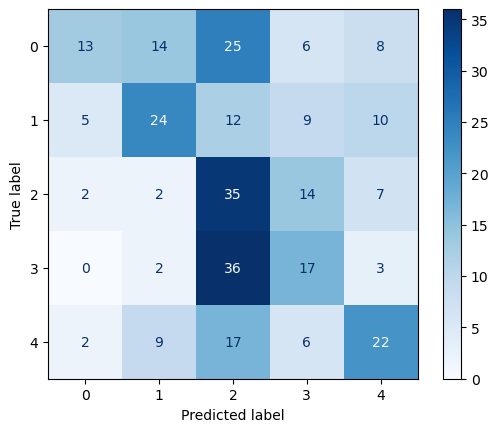

In [43]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)#, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

The model is the best one so far, but far from satisfactory. 

### Pretrained ResNet Model

Pre-trained models are pre-built machine learning models that have already been trained on large datasets, such as ImageNet or COCO. Such datasets often contain millions of images, which allows the models to learn a wide range of features and patterns. This makes them highly accurate and effective for a variety of tasks. Moreover, training a machine learning model from scratch can be a time-consuming process and by using pre-trained models, and typically much time and resources cab be saved by starting with a model that has already been trained.

ResNet models were developed especially for image classification. ResNet-50 is a pretrained model Convolutional Neural Network(CNN) model. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. 

Given the complexity and robustness of Resnet models compared to the previous ones, it was no surprise it performed better than all previous ones. 

#### Instantiate and train Resnet model

In [21]:
from keras.applications import ResNet50V2

In [44]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [45]:
#instantiate and train model 
np.random.seed(42)
res_model = models.Sequential()
res_model.add(resnet)
res_model.add(layers.Flatten())
res_model.add(layers.Dense(132, activation='relu'))
res_model.add(layers.Dense(5, activation='sigmoid'))


In [46]:
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 True
flatten_3 True
dense_6 True
dense_7 True
176


In [47]:
# freeze resnet layer
resnet.trainable = False

In [48]:
# verify resnet50v2 is set to False
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 False
flatten_3 True
dense_6 True
dense_7 True
4


In [49]:
# compile and train the model

res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

res_history = res_model.fit(cnn_train,
                    cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_test, cnn_test_labels),
                    validation_steps=10)

Epoch 1/10
27/27 [==============================] - 38s 1s/step - loss: 1.7654 - acc: 0.3350 - val_loss: 1.5362 - val_acc: 0.3900
Epoch 2/10
27/27 [==============================] - 34s 1s/step - loss: 1.1086 - acc: 0.5592 - val_loss: 1.4577 - val_acc: 0.4567
Epoch 3/10
27/27 [==============================] - 32s 1s/step - loss: 0.8290 - acc: 0.6900 - val_loss: 1.4704 - val_acc: 0.4500
Epoch 4/10
27/27 [==============================] - 32s 1s/step - loss: 0.6254 - acc: 0.7992 - val_loss: 1.4292 - val_acc: 0.4567
Epoch 5/10
27/27 [==============================] - 34s 1s/step - loss: 0.4777 - acc: 0.8717 - val_loss: 1.4437 - val_acc: 0.4667
Epoch 6/10
27/27 [==============================] - 33s 1s/step - loss: 0.3672 - acc: 0.9325 - val_loss: 1.4644 - val_acc: 0.4533
Epoch 7/10
27/27 [==============================] - 33s 1s/step - loss: 0.2804 - acc: 0.9617 - val_loss: 1.4507 - val_acc: 0.4733
Epoch 8/10
27/27 [==============================] - 32s 1s/step - loss: 0.2121 - acc: 0.98

### Evaluation

In [50]:
y_pred = res_model.predict(cnn_test)

10/10 [==============================] - 8s 685ms/step


In [51]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.33      0.86      0.48        66
           1       0.27      0.88      0.41        60
           2       0.26      0.87      0.40        60
           3       0.32      0.86      0.47        58
           4       0.35      0.82      0.49        56

   micro avg       0.30      0.86      0.45       300
   macro avg       0.31      0.86      0.45       300
weighted avg       0.31      0.86      0.45       300
 samples avg       0.34      0.86      0.47       300



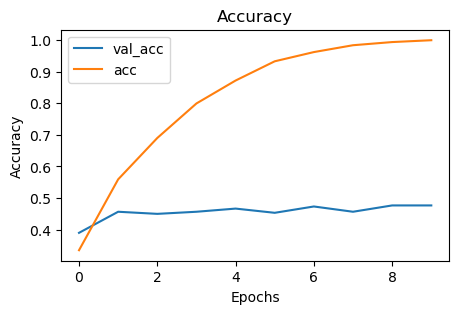

In [53]:
visualize_training_results(res_history)

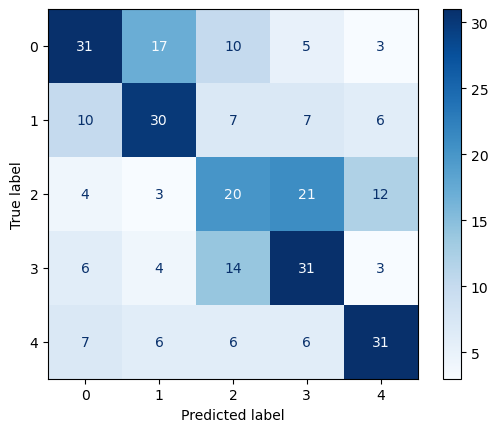

In [54]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)#, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

This model looks to be the best yet and has fairly high recall scores, but the precision and F-1 are still rather low. This means there are many false positives (yet few false negatives) in the predictions, meaning a predicted positive cannot be trusted. 

# Binary classification Modeling

While it is ideal to be able to identify specific diseases, detecting disease is an important first step. This next section seeked to classify images into one of two categories- healthy or diseased. Again, baseline neural network models were investigated, followed by a CNN and Resnet model. Images of diseased plants consisted of 80% of the dataset. In many of the models, it appeared to indiscriminately classify plants as diseased. However, a basic network performed relatively well, and the pretrained model far outperformed all others.

#### Train-test split for binary classification networks

In [21]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, df, 
                                                                                     test_size=0.2,
                                                                                     random_state=42,
                                                                                     shuffle=True)

### Basic Network with 1 hidden layer

In [70]:
#instantiate model
#np.random.seed(42)
binary_model_1 = models.Sequential()
binary_model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
binary_model_1.add(layers.Dense(2, activation='softmax'))

binary_model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
binary_results_1 = binary_model_1.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 5s 61ms/step - loss: 0.6514 - acc: 0.7908 - val_loss: 0.6101 - val_acc: 0.8133
Epoch 2/10
75/75 [==============================] - 4s 56ms/step - loss: 0.5908 - acc: 0.7967 - val_loss: 0.5607 - val_acc: 0.8133
Epoch 3/10
75/75 [==============================] - 5s 64ms/step - loss: 0.5554 - acc: 0.7967 - val_loss: 0.5308 - val_acc: 0.8133
Epoch 4/10
75/75 [==============================] - 5s 62ms/step - loss: 0.5345 - acc: 0.7967 - val_loss: 0.5126 - val_acc: 0.8133
Epoch 5/10
75/75 [==============================] - 5s 64ms/step - loss: 0.5222 - acc: 0.7967 - val_loss: 0.5014 - val_acc: 0.8133
Epoch 6/10
75/75 [==============================] - 5s 65ms/step - loss: 0.5151 - acc: 0.7967 - val_loss: 0.4946 - val_acc: 0.8133
Epoch 7/10
75/75 [==============================] - 5s 60ms/step - loss: 0.5108 - acc: 0.7967 - val_loss: 0.4902 - val_acc: 0.8133
Epoch 8/10
75/75 [==============================] - 5s 62ms/step - loss: 0.5084 - a

### Evaluation

In [74]:
bin_y_pred = binary_model_1.predict(binary_test)

10/10 [==============================] - 0s 12ms/step


In [75]:
print(classification_report(binary_test_labels, np.round(bin_y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.81      1.00      0.90       244

   micro avg       0.81      0.81      0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300
 samples avg       0.81      0.81      0.81       300



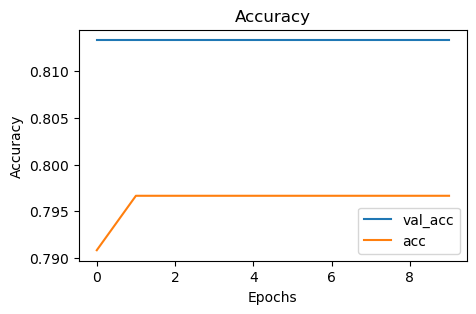

In [76]:
visualize_training_results(binary_results_1)

This model simply predicts all plants as diseased.

### Network with 2 hidden layers

In [22]:
#np.random.seed(42)
binary_model_2 = models.Sequential()
binary_model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_2.add(layers.Dense(32, activation='relu'))
binary_model_2.add(layers.Dense(2, activation='sigmoid'))
binary_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_2 = binary_model_2.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 9s 82ms/step - loss: 0.5368 - acc: 0.7775 - val_loss: 0.4829 - val_acc: 0.8100
Epoch 2/10
75/75 [==============================] - 5s 68ms/step - loss: 0.4979 - acc: 0.7975 - val_loss: 0.4778 - val_acc: 0.8100
Epoch 3/10
75/75 [==============================] - 5s 71ms/step - loss: 0.4913 - acc: 0.7975 - val_loss: 0.4741 - val_acc: 0.8100
Epoch 4/10
75/75 [==============================] - 6s 77ms/step - loss: 0.4843 - acc: 0.7975 - val_loss: 0.4810 - val_acc: 0.8100
Epoch 5/10
75/75 [==============================] - 5s 68ms/step - loss: 0.4765 - acc: 0.7975 - val_loss: 0.4666 - val_acc: 0.8100
Epoch 6/10
75/75 [==============================] - 5s 71ms/step - loss: 0.4716 - acc: 0.7967 - val_loss: 0.4891 - val_acc: 0.8067
Epoch 7/10
75/75 [==============================] - 5s 72ms/step - loss: 0.4627 - acc: 0.7967 - val_loss: 0.4738 - val_acc: 0.8100
Epoch 8/10
75/75 [==============================] - 5s 70ms/step - loss: 0.4511 - a

### Evaluation

In [190]:
y_pred = binary_model_2.predict(binary_test)

10/10 [==============================] - 0s 13ms/step


In [191]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.84      1.00      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.70      0.84      0.76       300
 samples avg       0.84      0.84      0.84       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
visualize_training_results(binary_results_2)

This model also predicted all diseased plants.

### Network with 3 hidden layers 

In [182]:
np.random.seed(42)
binary_model_3 = models.Sequential()
binary_model_3.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_3.add(layers.Dense(64, activation='relu'))
binary_model_3.add(layers.Dense(16, activation='relu'))
binary_model_3.add(layers.Dense(2, activation='sigmoid'))
binary_model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_3 = binary_model_3.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
377/377 [==============================] - 9s 21ms/step - loss: 0.2356 - acc: 0.9432 - val_loss: 0.2140 - val_acc: 0.9461
Epoch 2/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2232 - acc: 0.9436 - val_loss: 0.2171 - val_acc: 0.9461
Epoch 3/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2221 - acc: 0.9436 - val_loss: 0.2142 - val_acc: 0.9461
Epoch 4/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2200 - acc: 0.9436 - val_loss: 0.2144 - val_acc: 0.9461
Epoch 5/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2175 - acc: 0.9436 - val_loss: 0.2139 - val_acc: 0.9461
Epoch 6/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2173 - acc: 0.9436 - val_loss: 0.2134 - val_acc: 0.9461
Epoch 7/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2135 - acc: 0.9436 - val_loss: 0.2168 - val_acc: 0.9461
Epoch 8/10
377/377 [==============================] - 7s 19ms/step - 

### Evaluation

In [144]:
y_pred = binary_model_3.predict(binary_test)

10/10 [==============================] - 0s 4ms/step


In [147]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.81      1.00      0.90       244

   micro avg       0.81      0.81      0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300
 samples avg       0.81      0.81      0.81       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
visualize_training_results(binary_results_3)

Again, this model indiscriminately identifies plants as diseased.

### grid search to find best parameters for binary classification

In [23]:
def buildModel_binary(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu', input_shape=(49152,)))
        
    # Adding the output layer
    classifier.add(layers.Dense(2, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [194]:
binary_classifier = KerasRegressor(build_fn = buildModel_binary('adam'))
#What hyperparameter we want to play with
parameters = {'batch_size': [16],
              'epochs': [5, 10, 50],
              'optimizer': ['adam', 'sgd']}
binary_grid_search = GridSearchCV(estimator = binary_classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
binary_grid_search = binary_grid_search.fit(binary_train, binary_train_labels, verbose = 0)

INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3luv1t5v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3luv1t5v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfazmv3cy\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfazmv3cy\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj03pf8io\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj03pf8io\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzch3_fkv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzch3_fkv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppky8gxcm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppky8gxcm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1_t1go9t\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1_t1go9t\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8r4ft65c\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8r4ft65c\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq7fzz3b8\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq7fzz3b8\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsrmdw1yw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsrmdw1yw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzbx0pz87\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzbx0pz87\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3zyw0v4k\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3zyw0v4k\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2elgidg9\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2elgidg9\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiewzotno\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiewzotno\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf7bxxfrm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf7bxxfrm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx822m0l7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx822m0l7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5i8sl497\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5i8sl497\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpt8bg95rg\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpt8bg95rg\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpld2skuie\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpld2skuie\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfr89s49h\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfr89s49h\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_kzmahuk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_kzmahuk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdva7vft6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdva7vft6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoaxry385\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoaxry385\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpykcs4nzr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpykcs4nzr\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp433eeqs3\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp433eeqs3\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 6ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoqxrikvo\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoqxrikvo\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppaobegao\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppaobegao\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpna22vd13\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpna22vd13\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbothem26\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbothem26\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb5qj1b8a\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb5qj1b8a\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kgyzyg\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kgyzyg\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9tn06012\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9tn06012\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3laf7pv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3laf7pv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppliev12t\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppliev12t\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [196]:
# print best parameters
binary_best_parameters = binary_grid_search.best_params_
best_score = binary_grid_search.best_score_

print("Best Parameters: " + str(binary_best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 50, 'optimizer': 'adam'}


In [25]:
# train model using best parameters
best_binary_Classifier = buildModel_binary('adam')
HistoryBest_binary = best_binary_Classifier.fit(binary_train, binary_train_labels, batch_size = 16, epochs =50 , verbose = 0, validation_data=(binary_test, binary_test_labels))

### Evaluation

In [50]:
y_pred = best_binary_Classifier.predict(binary_test)

10/10 [==============================] - 0s 12ms/step


In [51]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.54      0.21      0.30        68
           1       0.80      0.95      0.87       232

   micro avg       0.78      0.78      0.78       300
   macro avg       0.67      0.58      0.58       300
weighted avg       0.74      0.78      0.74       300
 samples avg       0.78      0.78      0.78       300



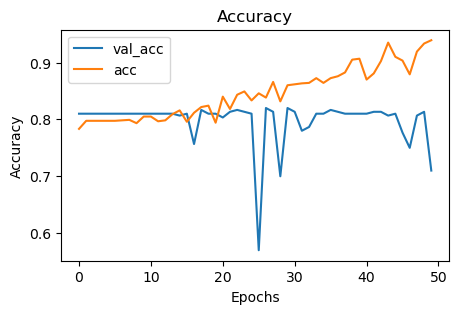

In [26]:
visualize_training_results(HistoryBest_binary)

While this model performs a bit better than the basic nerual network, it still does not satisfactorily classify the images. The validation data accuracy does not increase much after 10 epochs, indicating the additional epochs just add to the runtime without adding much value.

### Model with L2 regularization

In [105]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

binary_L2_model = models.Sequential()

# Add the input and first hidden layer
binary_L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(49152,)))

# Add another hidden layer
binary_L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
binary_L2_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L2_model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L2_model_results = binary_L2_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
75/75 [==============================] - 9s 107ms/step - loss: 2.1661 - acc: 0.7233 - val_loss: 1.3166 - val_acc: 0.8367
Epoch 2/5
75/75 [==============================] - 8s 103ms/step - loss: 1.3678 - acc: 0.7142 - val_loss: 1.1019 - val_acc: 0.8367
Epoch 3/5
75/75 [==============================] - 7s 98ms/step - loss: 0.8864 - acc: 0.7750 - val_loss: 0.7355 - val_acc: 0.8200
Epoch 4/5
75/75 [==============================] - 8s 107ms/step - loss: 0.6610 - acc: 0.8133 - val_loss: 0.6923 - val_acc: 0.8367
Epoch 5/5
75/75 [==============================] - 8s 102ms/step - loss: 0.6832 - acc: 0.7975 - val_loss: 0.6794 - val_acc: 0.7700


### Evaluation

In [106]:
y_pred = binary_L2_model.predict(binary_test)

10/10 [==============================] - 0s 8ms/step


In [107]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.33      0.41      0.37        49
           1       0.88      0.84      0.86       251

   micro avg       0.77      0.77      0.77       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.79      0.77      0.78       300
 samples avg       0.77      0.77      0.77       300



In [ ]:
visualize_training_results(binary_L2_model_results)

Like the multiclass, this performed similar to the grid search.

### Model with L1 regularization

In [108]:
np.random.seed(42)

binary_L1_model = models.Sequential()

# Add the input and first hidden layer
binary_L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(49152,)))

# Add a hidden layer
binary_L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
binary_L1_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L1_model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L1_model_val = binary_L1_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
75/75 [==============================] - 11s 139ms/step - loss: 28.7681 - acc: 0.7358 - val_loss: 7.4034 - val_acc: 0.8367
Epoch 2/5
75/75 [==============================] - 9s 124ms/step - loss: 7.8569 - acc: 0.7542 - val_loss: 5.8849 - val_acc: 0.8367
Epoch 3/5
75/75 [==============================] - 9s 119ms/step - loss: 6.3824 - acc: 0.7467 - val_loss: 6.4852 - val_acc: 0.8367
Epoch 4/5
75/75 [==============================] - 9s 121ms/step - loss: 6.0883 - acc: 0.7567 - val_loss: 5.3566 - val_acc: 0.8367
Epoch 5/5
75/75 [==============================] - 10s 135ms/step - loss: 5.3335 - acc: 0.7908 - val_loss: 5.2321 - val_acc: 0.8367


### Evaluation

In [109]:
y_pred = binary_L1_model.predict(binary_test)

10/10 [==============================] - 0s 8ms/step


In [110]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.84      1.00      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.70      0.84      0.76       300
 samples avg       0.84      0.84      0.84       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
visualize_training_results(binary_L1_model_val)

Again, this only predicted diseased plants.

### Model with dropout regularization

In [141]:
np.random.seed(42)
binary_dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
binary_dropout_model.add(layers.Dropout(0.3, input_shape=(49152,)))

# Add the first hidden layer
binary_dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
binary_dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the output layer
binary_dropout_model.add(layers.Dense(2, activation='softmax'))


# Compile the model
binary_dropout_model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['acc'])

# Train the model
binary_dropout_model_val = binary_dropout_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
75/75 [==============================] - 9s 104ms/step - loss: 1.9269 - acc: 0.6775 - val_loss: 0.6675 - val_acc: 0.8100
Epoch 2/5
75/75 [==============================] - 8s 108ms/step - loss: 0.6370 - acc: 0.7750 - val_loss: 0.6462 - val_acc: 0.8367
Epoch 3/5
75/75 [==============================] - 8s 109ms/step - loss: 0.6280 - acc: 0.7892 - val_loss: 0.4425 - val_acc: 0.8367
Epoch 4/5
75/75 [==============================] - 10s 130ms/step - loss: 0.6019 - acc: 0.7883 - val_loss: 0.5617 - val_acc: 0.8367
Epoch 5/5
75/75 [==============================] - 8s 110ms/step - loss: 0.5703 - acc: 0.7908 - val_loss: 0.5288 - val_acc: 0.8367


In [205]:
y_pred = binary_dropout_model.predict(binary_test)

10/10 [==============================] - 0s 12ms/step


In [206]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.84      1.00      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.70      0.84      0.76       300
 samples avg       0.84      0.84      0.84       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
visualize_training_results(binary_dropout_model_val)

###  CNN Binary Classification Model

This one performed much better than the basic neural network models, but still was unreliable in identifying healthy plants.

#### train-test split

In [57]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images,
                                                                                                     df, 
                                                                                                     test_size=0.2, 
                                                                                                     random_state=42,
                                                                                                     shuffle=True)

In [58]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))


Epoch 1/10
75/75 [==============================] - 11s 133ms/step - loss: 0.4953 - acc: 0.8033 - val_loss: 0.5314 - val_acc: 0.7667
Epoch 2/10
75/75 [==============================] - 9s 120ms/step - loss: 0.4765 - acc: 0.8083 - val_loss: 0.5157 - val_acc: 0.7667
Epoch 3/10
75/75 [==============================] - 10s 132ms/step - loss: 0.4607 - acc: 0.8083 - val_loss: 0.5392 - val_acc: 0.7667
Epoch 4/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4417 - acc: 0.8092 - val_loss: 0.4844 - val_acc: 0.7667
Epoch 5/10
75/75 [==============================] - 9s 123ms/step - loss: 0.4259 - acc: 0.8083 - val_loss: 0.4884 - val_acc: 0.7667
Epoch 6/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4102 - acc: 0.8058 - val_loss: 0.4980 - val_acc: 0.7667
Epoch 7/10
75/75 [==============================] - 9s 122ms/step - loss: 0.3992 - acc: 0.8125 - val_loss: 0.5933 - val_acc: 0.7667
Epoch 8/10
75/75 [==============================] - 10s 132ms/step - loss

### Evaluation

In [62]:
y_pred = binary_cnn_model.predict(cnn_binary_test)

10/10 [==============================] - 1s 62ms/step


In [63]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.58      0.20      0.30        70
           1       0.80      0.96      0.87       230

   micro avg       0.78      0.78      0.78       300
   macro avg       0.69      0.58      0.58       300
weighted avg       0.75      0.78      0.74       300
 samples avg       0.78      0.78      0.78       300



Although a small improvement, like most models, this one is still failing to accurately classify healthy plants.

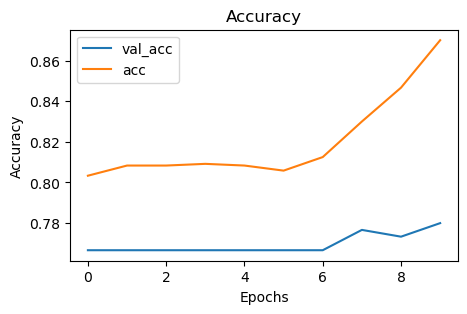

In [61]:
visualize_training_results(binary_cnn_results)

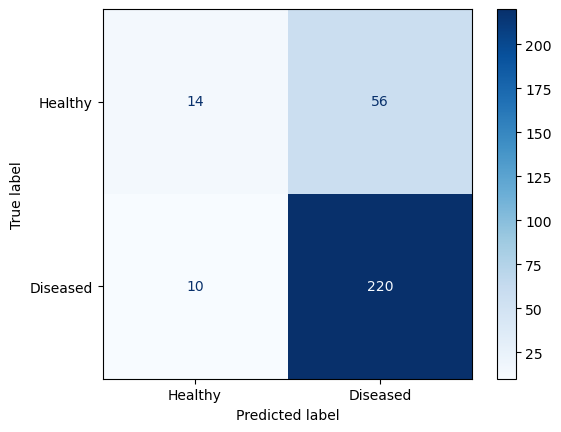

In [64]:
#confusion_matrix

cnf_matrix = confusion_matrix(cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

Clearly an improvement from the basic model, but still unreliable performance.

# pretrained binary classification model

This model was signaficantly better than any others at classifying the images correctly, especially for the healthy class. While still plenty of room for improvement, it performs acceptably.

In [28]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                        

                                                                                                  
 conv2_block3_preact_bn (Ba  (None, 32, 32, 256)          1024      ['conv2_block2_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 32, 32, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_blo

 rmalization)                                                                                     
                                                                                                  
 conv3_block2_1_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 18, 18, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 16, 16, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
          

 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 512)            0         ['conv3_block3_out[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 8, 8, 512)            0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 8, 8, 512)            2048      ['conv3_block4_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block3_1_conv (Conv2  (None, 8, 8, 256)            262144    ['conv4_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 rmalization)                                                                                     
                                                                                                  
 conv4_block5_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 8, 8, 1024)           0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
          

 conv5_block2_preact_bn (Ba  (None, 4, 4, 2048)           8192      ['conv5_block1_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv5_block2_preact_relu (  (None, 4, 4, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 4, 4, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalizati

In [29]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
binary_res_model = models.Sequential()
binary_res_model.add(resnet)
binary_res_model.add(layers.Flatten())
binary_res_model.add(layers.Dense(132, activation='relu'))
binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [30]:
# freeze resnet layer and verify
resnet.trainable = False

for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    

print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [31]:
# train model
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])



binary_res_history = binary_res_model.fit(cnn_binary_train,
                    cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_binary_test, cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 81s 3s/step - loss: 0.4753 - acc: 0.8325 - val_loss: 0.4490 - val_acc: 0.8200
Epoch 2/10
27/27 [==============================] - 65s 2s/step - loss: 0.3253 - acc: 0.8650 - val_loss: 0.3947 - val_acc: 0.8233
Epoch 3/10
27/27 [==============================] - 66s 2s/step - loss: 0.2531 - acc: 0.8975 - val_loss: 0.3529 - val_acc: 0.8400
Epoch 4/10
27/27 [==============================] - 68s 3s/step - loss: 0.2056 - acc: 0.9225 - val_loss: 0.3480 - val_acc: 0.8267
Epoch 5/10
27/27 [==============================] - 69s 3s/step - loss: 0.1661 - acc: 0.9458 - val_loss: 0.3263 - val_acc: 0.8633
Epoch 6/10
27/27 [==============================] - 77s 3s/step - loss: 0.1369 - acc: 0.9667 - val_loss: 0.3263 - val_acc: 0.8567
Epoch 7/10
27/27 [==============================] - 80s 3s/step - loss: 0.1138 - acc: 0.9717 - val_loss: 0.3102 - val_acc: 0.8600
Epoch 8/10
27/27 [==============================] - 79s 3s/step - loss: 0.0931 - acc: 0.

### Evaluation

In [32]:
y_pred = binary_res_model.predict(cnn_binary_test)

10/10 [==============================] - 20s 1s/step


In [33]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66        72
           1       0.84      0.97      0.90       228

   micro avg       0.84      0.87      0.85       300
   macro avg       0.84      0.76      0.78       300
weighted avg       0.84      0.87      0.84       300
 samples avg       0.83      0.87      0.85       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


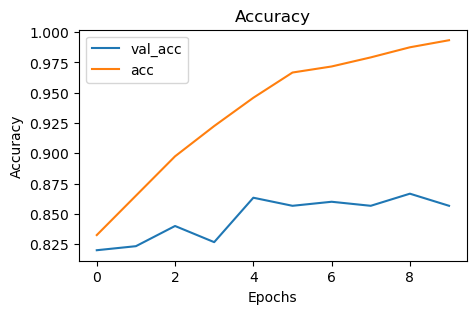

In [34]:
visualize_training_results(binary_res_history)

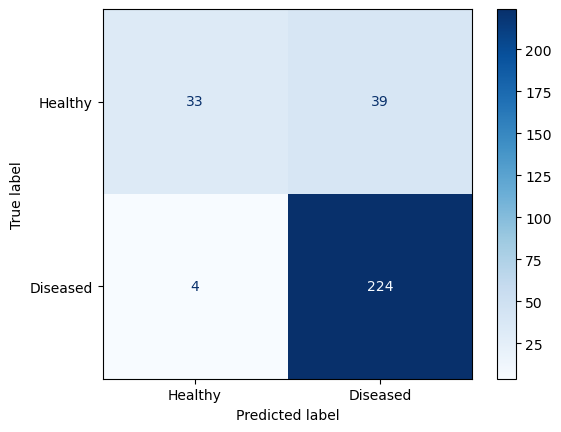

In [35]:
#confusion_matrix

cnf_matrix = confusion_matrix(cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

While there is certainly room for improvement, this model is by far the best, as it is able to identify healthy and diseased plants at a rate that could be acceptable.

# Resnet model on full dataset

After finding a relatively well performing model, it was then evaluated on the entire image dataset. A model trained on just the smaller number of images performed very poorly, so new models were trained for both multiclass and binary classification. Performance was not as good as models trained and evaluated on the smaller dataset. 

#### data preparation

In [3]:
full_data_dir = 'data/train'

# Get all the data in the directory data/train and reshape 
full_train_generator = ImageDataGenerator().flow_from_directory(
        full_data_dir, 
        target_size=(128, 128), batch_size=5656)

# Create the datasets
all_train_images, all_y_train = next(full_train_generator)


Found 5656 images belonging to 5 classes.


#### preview image labels

In [4]:
# preview shape
print(np.shape(all_train_images))
print(np.shape(all_y_train))

(5656, 128, 128, 3)
(5656, 5)


### Binary labeling


In [5]:
# make dataframe and preview
all_df = pd.DataFrame(all_y_train)
all_df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [6]:
all_df.loc[all_df[4]==1,"Healthy"]=1
all_df.loc[all_df[4]==0,"Healthy"]=0
all_df.loc[all_df[4]==1,"Diseased"]=0
all_df.loc[all_df[4]==0,"Diseased"]=1
all_df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
all_df.head()

,Healthy,Diseased
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [7]:
# check for any null entries
all_df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [106]:
print(classification_report(all_cnn_test_labels, np.round(y_pred)))

visualize_training_results(all_res_history)

#confusion matrix(

cnf_matrix = confusion_matrix(all_cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap=plt.cm.Blues);print("healthy: ", all_df['Healthy'].sum())
print("diseased: ", all_df['Diseased'].sum())

print("Percent of images belonging to healthy plants: ", round(all_df['Healthy'].sum() / all_df['Diseased'].sum() * 100, 2))

healthy:  316.0
diseased:  5340.0
Percent of images belonging to healthy plants:  5.92


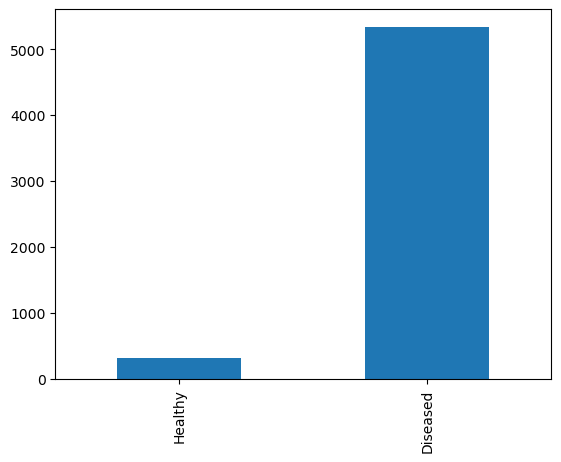

In [84]:
all_df.sum().plot(kind='bar');

#### train-test split

In [10]:
# multiclass
all_cnn_train, all_cnn_test, all_cnn_train_labels, all_cnn_test_labels= train_test_split(all_train_images, 
                                                                                         all_y_train, 
                                                                                         test_size=0.2, 
                                                                                         random_state=42,
                                                                                         shuffle=True)

In [85]:
# binary
all_cnn_binary_train, all_cnn_binary_test, all_cnn_binary_train_labels, all_cnn_binary_test_labels= train_test_split(all_train_images,
                                                                                                                     all_df, test_size=0.2, 
                                                                                                                     random_state=42,
                                                                                                                     shuffle=True)


## Predict using model trained on small dataset on all data

In [71]:
y_pred = binary_res_model.predict(all_cnn_binary_test)

36/36 [==============================] - 66s 2s/step


In [72]:
print(classification_report(all_cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.95      1.00      0.97      1071

   micro avg       0.95      0.95      0.95      1132
   macro avg       0.47      0.50      0.49      1132
weighted avg       0.90      0.95      0.92      1132
 samples avg       0.95      0.95      0.95      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model is inadequete for identifying healthy plants when presented with the full dataset. Thus, it will be necessary to train a new resnet model.

# Multiclass Resnet model trained on full dataset

In [73]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [75]:
#instantiate and train model  
np.random.seed(42)
all_res_model = models.Sequential()
all_res_model.add(resnet)
all_res_model.add(layers.Flatten())
all_res_model.add(layers.Dense(132, activation='relu'))
all_res_model.add(layers.Dense(5, activation='sigmoid'))


In [76]:
for layer in all_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(all_res_model.trainable_weights))

resnet50v2 True
flatten_1 True
dense_2 True
dense_3 True
176


In [77]:
resnet.trainable = False

In [78]:
for layer in all_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(all_res_model.trainable_weights))

resnet50v2 False
flatten_1 True
dense_2 True
dense_3 True
4


In [79]:
all_res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [80]:
all_res_history = all_res_model.fit(all_cnn_train,
                    all_cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(all_cnn_test, all_cnn_test_labels),
                    validation_steps=10)

Epoch 1/10
27/27 [==============================] - 273s 9s/step - loss: 50.3420 - acc: 0.3853 - val_loss: 45.2471 - val_acc: 0.3074
Epoch 2/10
27/27 [==============================] - 230s 9s/step - loss: 33.2439 - acc: 0.4191 - val_loss: 47.4465 - val_acc: 0.3216
Epoch 3/10
27/27 [==============================] - 189s 7s/step - loss: 30.5328 - acc: 0.4233 - val_loss: 23.5152 - val_acc: 0.4064
Epoch 4/10
27/27 [==============================] - 118s 4s/step - loss: 26.4777 - acc: 0.4443 - val_loss: 31.1398 - val_acc: 0.4929
Epoch 5/10
27/27 [==============================] - 115s 4s/step - loss: 24.4708 - acc: 0.4569 - val_loss: 24.5505 - val_acc: 0.5150
Epoch 6/10
27/27 [==============================] - 119s 4s/step - loss: 24.4672 - acc: 0.4562 - val_loss: 24.2635 - val_acc: 0.5389
Epoch 7/10
27/27 [==============================] - 116s 4s/step - loss: 22.1957 - acc: 0.4589 - val_loss: 21.2281 - val_acc: 0.3472
Epoch 8/10
27/27 [==============================] - 184s 7s/step - lo

### Evaluation

In [81]:
y_pred = all_res_model.predict(all_cnn_test)

36/36 [==============================] - 27s 692ms/step


In [95]:
print(classification_report(all_cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.45      0.09      0.15       101
           1       0.54      0.10      0.16       308
           2       0.00      0.00      0.00       138
           3       0.83      0.04      0.07       506
           4       0.17      0.03      0.04        79

   micro avg       0.54      0.05      0.10      1132
   macro avg       0.40      0.05      0.09      1132
weighted avg       0.57      0.05      0.09      1132
 samples avg       0.04      0.05      0.05      1132



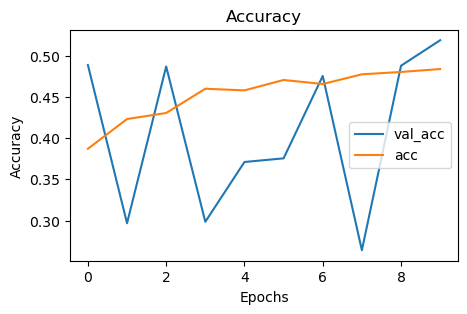

In [96]:
visualize_training_results(all_res_history)

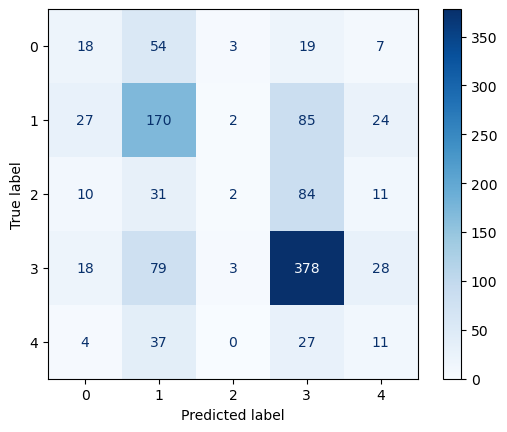

In [99]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(all_cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)#, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

# Resnet binary model on full dataset

In [12]:
#instantiate and train model  -
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))
all_binary_res_model = models.Sequential()
all_binary_res_model.add(resnet)
all_binary_res_model.add(layers.Flatten())
all_binary_res_model.add(layers.Dense(132, activation='relu'))
all_binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [13]:
resnet.trainable = False

In [14]:
for layer in all_binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(all_binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [15]:
np.random.seed(42)

all_binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
all_binary_res_history = all_binary_res_model.fit(all_cnn_binary_train,
                    all_cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(all_cnn_binary_test, all_cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 238s 8s/step - loss: 8.1307 - acc: 0.9047 - val_loss: 5.0235 - val_acc: 0.9417
Epoch 2/10
27/27 [==============================] - 227s 8s/step - loss: 4.8344 - acc: 0.9304 - val_loss: 4.2549 - val_acc: 0.9417
Epoch 3/10
27/27 [==============================] - 222s 8s/step - loss: 4.4966 - acc: 0.9224 - val_loss: 3.0947 - val_acc: 0.9302
Epoch 4/10
27/27 [==============================] - 235s 9s/step - loss: 3.7092 - acc: 0.9332 - val_loss: 4.2473 - val_acc: 0.9417
Epoch 5/10
27/27 [==============================] - 226s 8s/step - loss: 3.3666 - acc: 0.9330 - val_loss: 4.0339 - val_acc: 0.9417
Epoch 6/10
27/27 [==============================] - 229s 9s/step - loss: 2.8326 - acc: 0.9344 - val_loss: 2.3271 - val_acc: 0.8843
Epoch 7/10
27/27 [==============================] - 228s 9s/step - loss: 2.8290 - acc: 0.9381 - val_loss: 3.0782 - val_acc: 0.8295
Epoch 8/10
27/27 [==============================] - 228s 9s/step - loss: 2.5911 -

### Evaluation

In [16]:
y_pred = all_binary_res_model.predict(all_cnn_binary_test)

36/36 [==============================] - 55s 1s/step


In [17]:
print(classification_report(all_cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.30      0.12      0.17        66
           1       0.95      0.99      0.97      1066

   micro avg       0.93      0.94      0.93      1132
   macro avg       0.62      0.55      0.57      1132
weighted avg       0.91      0.94      0.92      1132
 samples avg       0.93      0.94      0.93      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model performs significantly worse than the same one trained with the smaller dataset. 

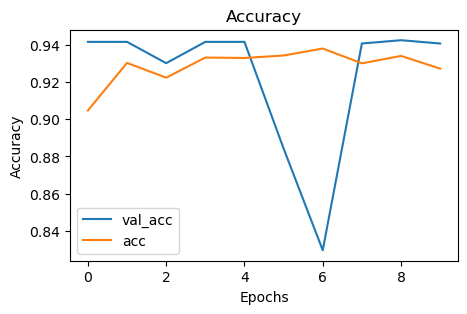

In [18]:
visualize_training_results(all_binary_res_history)

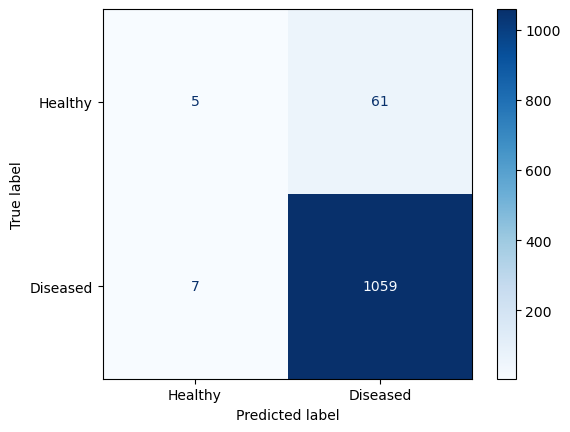

In [19]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(all_cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=all_cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

# Summary of model scores

# Multiclass summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .26       | .25    | .16       |   |
| 2 hidden layers        | .29       | .30    | .28       |   |
| 3 hidden layers        | .03       | .20    | .06       |   |
| Grid Search            | .33       | .26    | .23       |   |
| L2 Regularization      | .35       | .35    | .29       |   |
| L1 Regularization      | .04       | .20    | .06       |   |
| Dropout Regularization | .04       | .20    | .06       |   |
| CNN Model              | .29       | .69    | .39       |   |
| ResNet50V2 Model       | .31       | .86    | .45       |   |
| Full ResNet50V2        | .40       | .05    | .09       |   |
|                        |           |        |           |   |

# Binary summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .41       | .50    | .45       |   |
| 1 hidden layer         | .42       | .50    | .46       |   |
| 2 hidden layer         | .41       | .50    | .45       |   |
| Grid Search            | .67       | .58    | .58       |   |
| L2 Regularization      | .61       | .62    | .61       |   |
| L1 Regularization      | .42       | .50    | .46       |   |
| Dropout Regularization | .42       | .50    | .46       |   |
| CNN Model              | .69       | .58    | .58       |   |
| ResNet50V2 Model       | .84       | .76    | .78       |   |
| Full ResNet50V2        | .62       | .55    | .57       |   |
|                        |           |        |           |   |

